##  Battle Of The Neighborhoods: Best Mexican Resturant in New York 

New York City has a long history of being a center of multicultrualism in the Modern United States, with the various Hispanic Cultures leaving their mark in this melting pot of the West. this project in particular will be focusing on listing and visualizing which of the New york neighborhoods have the most popular Mexican food spots.

## Data

For this project we need the following data :

    New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
       - Data source : https://cocl.us/new_york_dataset
       - Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
    Mexican resturants in each neighborhood of NYC
       - Data source : Fousquare API
       - Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Chinese resturants.
    GeoSpace data
       - Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
       - Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

## Approach

   - Collect the new york city data from https://cocl.us/new_york_dataset
   - Using FourSquare API we will find all venues for each neighborhood.
   - Filter out all venues that are Mexican Resturants.
   - Find rating , tips and like count for each Mexican Resturants using FourSquare API.
   - Using rating for each resturant , we will sort that data.
   - Visualize the Ranking of neighborhoods using folium library(python)


# Questions To Answer 

- What is the best location in NYC for Mexican Cusine? 
- Which areas have potential Mexican Resturaunt Markets? 
- Which areas lack Mexican Resturaunts? 
- Which is the best place to peoples preference? 

# Analysis 

Libraries will be imported below

In [4]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
import os

from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0           conda-forge
    geopy:         1.22.0-pyh9f0ad1d_0 conda-forge


geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All re

Importing the Foursquare API Credentials and gathering the Geolocation Data

In [12]:
CLIENT_ID = '1Z0LDBQJJJE1QTRTTMDGGLLONBIRF0O1JTM3L3O0NUTIRTHF' # your Foursquare ID
CLIENT_SECRET = 'SFL50HSTLZUXELJZOBYXLK3KQILOQI20F1GNW3KH5MAXKKE1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT ID: ' + CLIENT_ID)
print('CLIENT SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT ID: 1Z0LDBQJJJE1QTRTTMDGGLLONBIRF0O1JTM3L3O0NUTIRTHF
CLIENT SECRET:SFL50HSTLZUXELJZOBYXLK3KQILOQI20F1GNW3KH5MAXKKE1


In [57]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Define the Dataframe

In [58]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [59]:
ny_data.shape

(306, 4)

Now we map out the NYC dataframe

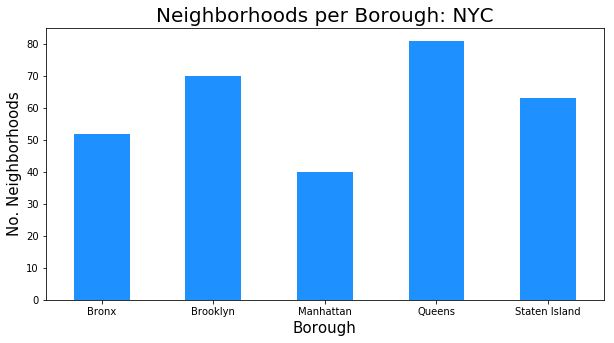

In [60]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Now lets analyze the Mexican resturants in each neighborhood and Borough and graph the results

In [126]:
# queens has most neighborhoods
# prepare neighborhood list that contains pizza resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(ny_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    print(row)
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:1
['Bronx', '

KeyError: 'groups'

Now lets clean and graph the data

In [127]:
mexican_rest_ny.to_csv('mexican_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [128]:
mexican_rest_ny.shape

(103, 4)

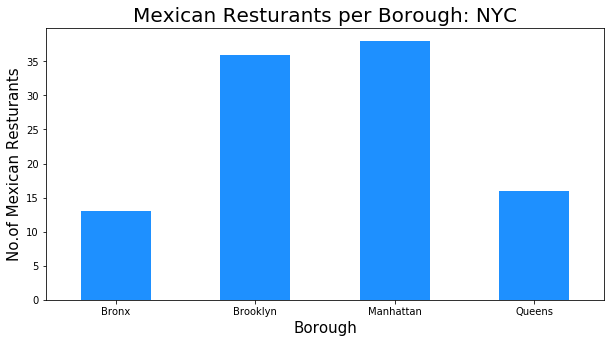

In [131]:
mexican_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Mexican Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Mexican Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Manhattan and Brooklyn seem to be the two most popular Boroughs in this category of cuisine, lets look at the distrbution in neighborhoods

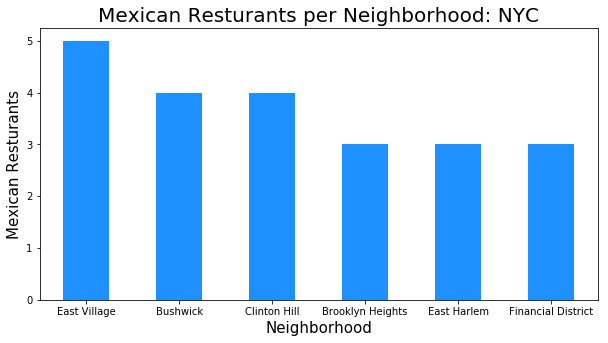

In [132]:
NOofNeigh = 6 # top number for graphing all the same past 6
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Mexican Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Mexican Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [134]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='East Village']

,Borough,Neighborhood,ID,Name
69,Manhattan,East Village,544153df498e8f7dae118d8e,Empellón Al Pastor
70,Manhattan,East Village,4d322023c75a6ea8cc220bae,El Camion Cantina
71,Manhattan,East Village,54f90055498e6ce6a801f8f3,Taqueria St. Marks
72,Manhattan,East Village,5209469f11d2d4f85e5b7427,Tacos Cuautla Morelos
73,Manhattan,East Village,49e80026f964a52037651fe3,Zaragoza Mexican Deli-Grocery


In [135]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
mexican_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ef27594546946258facdf0d'}, 'response': {'venue': {'id': '5217dd2811d2d06ccafb77d3', 'name': 'Estrellita Poblana V', 'contact': {'phone': '7188843825', 'formattedPhone': '(718) 884-3825'}, 'location': {'address': '240 W 231st St', 'lat': 40.879687039717524, 'lng': -73.906256832975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879687039717524, 'lng': -73.906256832975}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estrellita-poblana-v/5217dd2811d2d06ccafb77d3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://www.estrel

KeyError: 'venue'

In [136]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny_csv.csv')

In [137]:
mexican_rest_stats_ny.shape

(50, 7)

In [138]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [139]:
mexican_rest_stats_ny['Likes']=mexican_rest_stats_ny['Likes'].astype('float64')
mexican_rest_stats_ny['Tips']=mexican_rest_stats_ny['Tips'].astype('float64')
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [141]:
mexican_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,42.520000,7.028000,18.160000
std,54.726496,2.195825,21.865414
min,0.000000,0.000000,0.000000
25%,8.250000,7.025000,3.000000
50%,22.500000,7.550000,7.000000
75%,43.750000,8.075000,32.750000
max,238.000000,9.200000,92.000000


In [143]:
# Resturant with maximum Likes
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5ae8ed8eb3c961002b3360da
Name                             Oxomoco
Likes                                238
Rating                               8.8
Tips                                  51
Name: 16, dtype: object

In [144]:
# Resturant with maxmium Rating
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.2
Tips                                  73
Name: 7, dtype: object

In [145]:
# Resturant with maximum Tips
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              49bca8d2f964a52044541fe3
Name                             Pequeña
Likes                                223
Rating                               7.9
Tips                                  92
Name: 33, dtype: object

In [146]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
23,Parkchester,9.200000
19,North Side,8.600000
5,Chinatown,8.500000
30,Westchester Square,8.400000
14,Greenpoint,8.266667
15,Kensington,8.100000
4,Bushwick,7.950000
25,Prospect Heights,7.933333
11,Fort Greene,7.900000
28,South Side,7.800000


In [147]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.500000
1,Brooklyn,7.169444
0,Bronx,6.523077


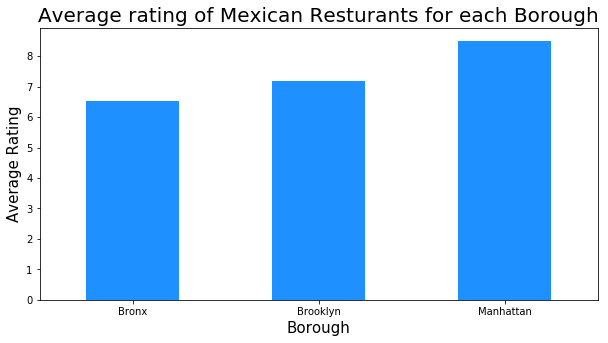

In [148]:
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Mexican Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [150]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Chinatown,8.500000
14,Greenpoint,8.266667
15,Kensington,8.100000
19,North Side,8.600000
23,Parkchester,9.200000
30,Westchester Square,8.400000


In [151]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,8.500000
1,Brooklyn,Greenpoint,40.730201,-73.954241,8.266667
2,Brooklyn,Kensington,40.642382,-73.980421,8.100000
3,Brooklyn,North Side,40.714823,-73.958809,8.600000
4,Bronx,Parkchester,40.837938,-73.856003,9.200000
5,Bronx,Westchester Square,40.840619,-73.842194,8.400000


In [152]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [153]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

# CONCLUSION 

the data shows that Manhattan and Queens have the best rated Mexican Resturants on average, with the Bronx and Queens having the least amount of Mexican resturants per borough. East Village in Manhattan has the most Mexican resturants per neighborhood, However Manhattan only had one highly rated resturant with Brookyln and the Bronx holding multiple highly rated resturants. Based on this information i would conclude that Brookyln specifically Greenpoint or Northside will have the highest rated Mexican food in NYC.